In [19]:
import math

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

def _pdist(a, b=None):
    sq_sum_a = tf.reduce_sum(tf.square(a), reduction_indices=[1])
    if b is None:
        return -2 * tf.matmul(a, tf.transpose(a)) + \
            tf.reshape(sq_sum_a, (-1, 1)) + tf.reshape(sq_sum_a, (1, -1))
    sq_sum_b = tf.reduce_sum(tf.square(b), reduction_indices=[1])
    return -2 * tf.matmul(a, tf.transpose(b)) + \
        tf.reshape(sq_sum_a, (-1, 1)) + tf.reshape(sq_sum_b, (1, -1))

def unimodal_magnet_loss(features, labels, margin=1.0, unique_labels=None):
    """Simple unimodal magnet loss.
    See::
        Rippel, Paluri, Dollar, Bourdev: Metric Learning With Adaptive
        Density Discrimination. ICLR, 2016.
    Parameters
    ----------
    features : tf.Tensor
        A matrix of shape NxM that contains the M-dimensional feature vectors
        of N objects (floating type).
    labels : tf.Tensor
        The one-dimensional array of length N that contains for each feature
        the associated class label (integer type).
    margin : float
        A scalar margin hyperparameter.
    unique_labels : Optional[tf.Tensor]
        Optional tensor of unique values in `labels`. If None given, computed
        from data.
    Returns
    -------
    tf.Tensor
        A scalar loss tensor.
    """
    nil = tf.constant(0., tf.float32)
    one = tf.constant(1., tf.float32)
    minus_two = tf.constant(-2., tf.float32)
    eps = tf.constant(1e-4, tf.float32)
    margin = tf.constant(margin, tf.float32)

    num_per_class = None
    if unique_labels is None:
        unique_labels, sample_to_unique_y, num_per_class = tf.unique_with_counts(labels)
        num_per_class = tf.cast(num_per_class, tf.float32)

    y_mat = tf.cast(tf.equal(
        tf.reshape(labels, (-1, 1)), tf.reshape(unique_labels, (1, -1))),
        dtype=tf.float32)

    # If class_means is None, compute from batch data.
    if num_per_class is None:
        num_per_class = tf.reduce_sum(y_mat, reduction_indices=[0])
    class_means = tf.reduce_sum(
        tf.expand_dims(tf.transpose(y_mat), -1) * tf.expand_dims(features, 0),
        reduction_indices=[1]) / tf.expand_dims(num_per_class, -1)

    squared_distance = _pdist(features, class_means)

    num_samples = tf.cast(tf.shape(labels)[0], tf.float32)
    variance = tf.reduce_sum(
        y_mat * squared_distance) / (num_samples - one)

    const = one / (minus_two * (variance + eps))
    linear = const * squared_distance - y_mat * margin

    maxi = tf.reduce_max(linear, reduction_indices=[1], keepdims=True)
    loss_mat = tf.exp(linear - maxi)

    a = tf.reduce_sum(y_mat * loss_mat, reduction_indices=[1])
    b = tf.reduce_sum((one - y_mat) * loss_mat, reduction_indices=[1])
    loss = tf.maximum(nil, -tf.log(eps + a / (eps + b)))
    return tf.reduce_mean(loss), loss

def compute_reps(extract_fn, X, chunk_size):
    """Compute representations for input in chunks."""
    chunks = int(math.ceil(float(X.shape[0]) / chunk_size))
    reps = []
    for i in range(chunks):
        start = i * chunk_size
        stop = start + chunk_size
        chunk_reps = extract_fn(X[start:stop])
        reps.append(chunk_reps)
    return np.vstack(reps)


mnist = input_data.read_data_sets('MNIST_data')
x_train, y_train = mnist.train.images, mnist.train.labels
x_test, y_test = mnist.test.images, mnist.test.labels

learning_rate = 0.01
n_epochs = 100
batch_size = 1000
feature_size = 784
embed_size = 2

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(1000)
train_data = train_data.batch(batch_size)

iterator = tf.data.Iterator.from_structure(train_data.output_types,
                                          train_data.output_shapes)

features, label = iterator.get_next()

train_init_op = iterator.make_initializer(train_data)

w1 = tf.Variable(tf.random_normal(shape=[feature_size, 393], stddev=0.01), name="weights1")
b1 = tf.Variable(tf.zeros([1, 393]), name="bias1")
w2 = tf.Variable(tf.random_normal(shape=[393, embed_size], stddev=0.01), name="weights2")
b2 = tf.Variable(tf.zeros([1, embed_size]), name="bias2")

def encoder(features, feature_size, embed_size):
    h1 = tf.add(tf.matmul(tf.cast(features, tf.float32), w1), b1)
    h1 = tf.nn.relu(h1)

    h2 = tf.add(tf.matmul(tf.cast(h1, tf.float32), w2), b2)
    emb = tf.nn.sigmoid(h2)

    return emb

emb = encoder(features, feature_size, embed_size)
train_loss, _ = unimodal_magnet_loss(emb, label)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(train_loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    initial_reps = sess.run(emb, feed_dict={features: x_train})
    
    batch_losses = []
    for i in range(n_epochs):
        sess.run(train_init_op)
        total_loss = 0
        n_batches = 0
        try:
            while True:
                _, l = sess.run([optimizer, train_loss])
                batch_losses.append(l)
                total_loss += l
                n_batches += 1
        except tf.errors.OutOfRangeError:
            pass
        
        if i % 10 == 0:
            print('Average loss epoch {0}: {1}'.format(i, total_loss/n_batches))

        final_reps = sess.run(emb, feed_dict={features: x_train})

        test_reps = sess.run(emb, feed_dict={features: x_test})


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Average loss epoch 0: 0.926277220249176
Average loss epoch 10: 0.12370186163620515
Average loss epoch 20: 0.0927976556122303
Average loss epoch 30: 0.06846432777290995
Average loss epoch 40: 0.06329954022710974
Average loss epoch 50: 0.055407654561779714
Average loss epoch 60: 0.048354704017666256
Average loss epoch 70: 0.05114499647170305
Average loss epoch 80: 0.045151748305017295
Average loss epoch 90: 0.042064101790839976


In [ ]:
!pip show tensorflow

In [3]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox

In [4]:
def plot_embedding(X, y, imgs=None, title=None):
    # Adapted from http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        # plot colored number
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    # Add image overlays
    if imgs is not None and hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(imgs[i], cmap=plt.cm.gray_r), X[i])
            ax.add_artist(imagebox)

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

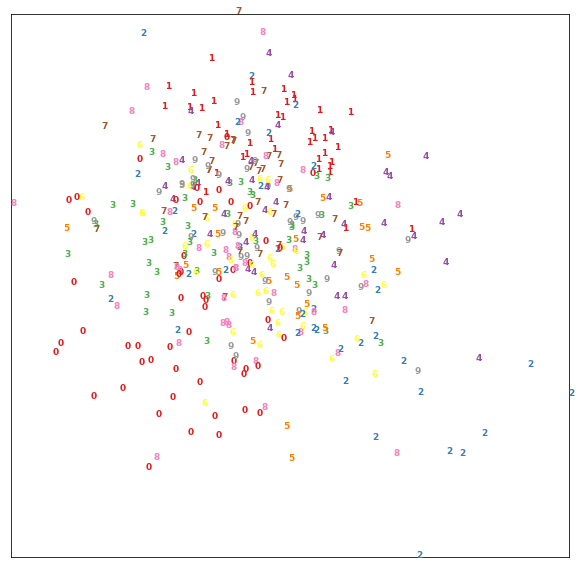

In [7]:
plot_embedding(initial_reps[:400], y_train[:400])

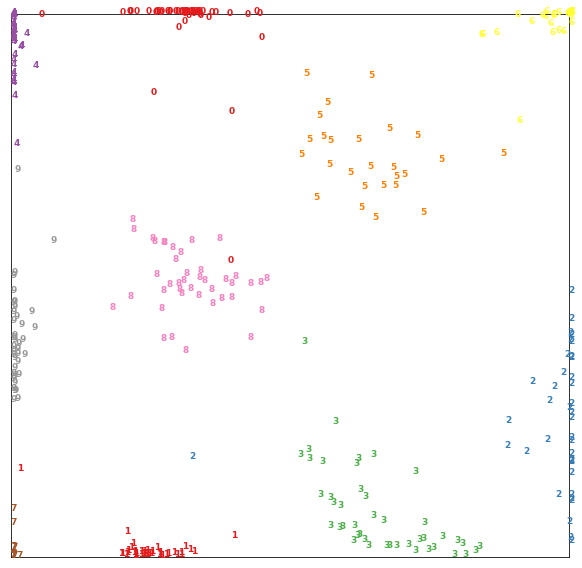

In [20]:
plot_embedding(final_reps[:400], y_train[:400])

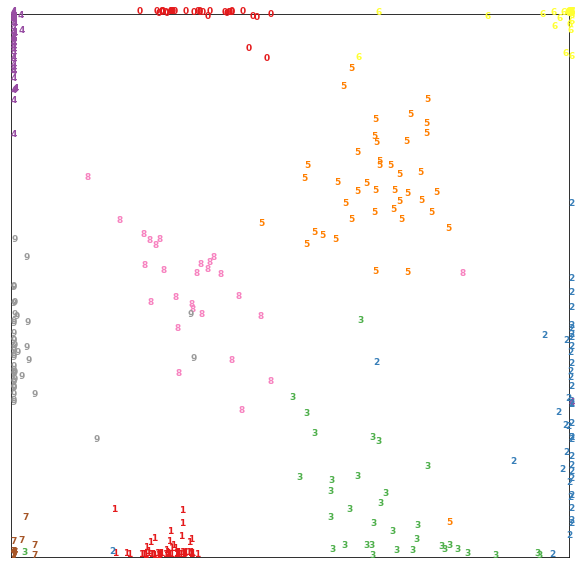

In [21]:
plot_embedding(test_reps[:400], y_test[:400])